In [1]:
# Import dependencies 
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import scipy.stats as stats
import pandas as pd

import datetime as dt

# Reflect Hawaii Climate DB Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, distinct

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# Declare a SQLAlchemy base using `automap_base()` to automatically generate my Python classes from my Postgresql DB tables
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create the SQLAlchemy inspector and connect it to the engine
# This allows the inspection of database tables from my Python code 
inspector = inspect(engine)

In [7]:
# Use SQLAlchemy reflection to get the details of the Measurement table
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# Use SQLAlchemy reflection to get the details of the Station table
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Create a session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [11]:
# How many measurement dates does the data in this table cover?
# This will tell me the total number of rows of measurement data (but not the unique dates those observations were taken)
session.query(func.count(Measurement.date)).all()

[(19550)]

In [12]:
# This will tell me the number of unique measurement dates covered by the data inb this table.
session.query(func.count(distinct(Measurement.date))).all()

[(2792)]

In [13]:
# Find the earliest measurement date
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [14]:
# Find the latest measurement date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

In [15]:
print(last_date)

('2017-08-23',)


In [16]:
# Calculate the date 1 year prior to the last data point in the database
latest_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
start_date = latest_date - dt.timedelta(days=365)
print(start_date)

2016-08-23 00:00:00


In [17]:
# Perform a query to retrieve the sum of the precipitation amount (across all stations) by date
# Sort the result by date
sel = [Measurement.date, 
       func.sum(Measurement.prcp)]
precipitation = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= start_date).\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()


In [18]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Remove rows with NA values
# Sort the dataframe by date

precipitation_df = pd.DataFrame(precipitation, columns=['measurement_date', 'precipitation_amount'])
precipitation_df.dropna(axis=0, how='any', inplace= True)
precipitation_df.sort_values(by='measurement_date')
precipitation_df.set_index('measurement_date', inplace=True)
precipitation_df.head()


,precipitation_amount
measurement_date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10


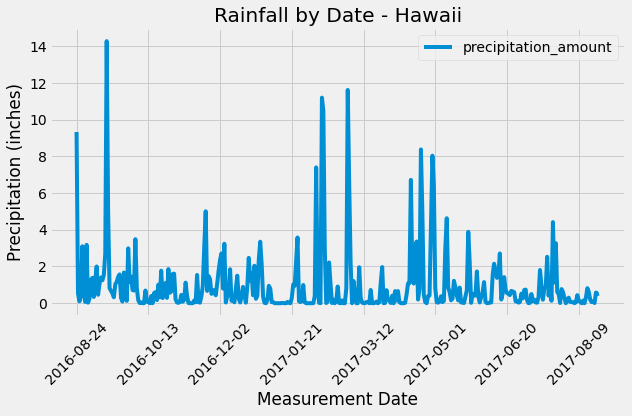

In [19]:
# Plot the results using the DataFrame plot method.

ax = precipitation_df.plot(rot=45, title = "Rainfall by Date - Hawaii", xlabel='Measurement Date', ylabel = "Precipitation (inches)", figsize=(9,6))
# precipitation_df.plot(rot=45)
plt.tight_layout()
plt.show()
ax.figure.savefig('Annual_Precipitation_Hawaii.png', bbox_inches='tight')

In [20]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation_amount
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


In [21]:
# Design a query to show how many stations are available in this dataset.
session.query(func.count(distinct(Measurement.station))).all()


[(9)]

In [22]:
# What are the most active stations? (i.e. what stations have the most measurements)?
# This query lists the stations and the counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.date)]
active_stations = session.query(*sel).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station.
sel = [Measurement.station,
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
station_temp_summary = session.query(*sel).\
        filter(Measurement.station == 'USC00519281').\
        group_by(Measurement.station)
for station in station_temp_summary:
    print(station)


('USC00519281', 54.0, 85.0, 71.66378066378067)


In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date, 
       Measurement.tobs]
station_temps = session.query(*sel).\
        filter(func.strftime(Measurement.date) >= start_date, Measurement.station == 'USC00519281').\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

# Create a datafrem containing the results of this query
station_temps_df = pd.DataFrame(station_temps, columns=['Measurement Date', 'Temperature'])
station_temps_df.head()

,Measurement Date,Temperature
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


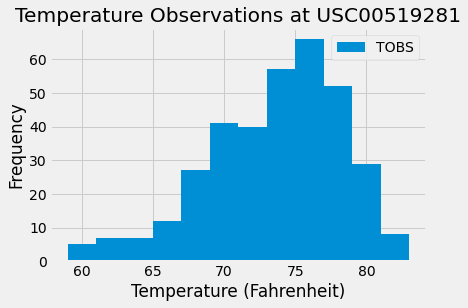

In [25]:
# Create a histogram to visualize the temperature observations from Station USC00519281 

plt.hist(station_temps_df['Temperature'],bins=12, density=False, label="TOBS")
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Temperature Observations at USC00519281")
plt.figsize=(10,7)
plt.savefig('Annual_Temps_USC00519281.png',bbox_inches='tight')
plt.show()


## Bonus Challenge Assignment

### Temperature Analysis I

Hawaii is reputed to enjoy mild weather all year. In this section we seek to answer the question as to whether there is a meaningful difference between the temperature in June and December.
- This analysis uses SQLAlchemy to extract the temperature data from June and December (of all years on record) into Pandas dataframes,
- It computes the average temperatures for June and December,
- It uses a paired t-test (because I am comparing 2 independent samples from the same population) to determine whether the difference in the means is statistically significant. 
    - Spoiler: It is!

In [26]:
# Extract June and December temperature data into dataframes

sel = [Measurement.date,
       Measurement.tobs]
June_temps = session.query(*sel).\
        filter(func.strftime('%m', Measurement.date) == '06').all()
December_temps = session.query(*sel).\
        filter(func.strftime('%m', Measurement.date) == '12').all()

June_df = pd.DataFrame(June_temps,columns=["Date","Temperature"])
December_df = pd.DataFrame(December_temps,columns=["Date","Temperature"])

#Identify the average temperature in June, and the average temperature in December 
June_average = June_df["Temperature"].mean()
December_average = December_df["Temperature"].mean()
print(June_average, December_average)

74.94411764705882 71.04152933421226


In [27]:
# Use the unpaired t-test to determine whether the difference in the means, if any, is statistically significant. 
# Null Hypothesis (0):There is no significant difference in the average temperatures of June compared to those of December
# Alternate Hypothesis (1): There is a significant difference in the average temperatures of June compared to those of December

stats.ttest_ind(June_df["Temperature"], December_df["Temperature"])
 
# In this case, the p-value is incredibly small, so we reject the null hypothesis of equal averages and conclude
# that the difference in temperature between June and December is significant 

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

### Temperature Analysis II

This section analyzes temperature data for my upcoming trip to Hawaii (12-20 to 01-02):
- It uses a function called calc_temps that accepts start and end dates and returns  the minimum, average, and maximum temperatures for that range of dates. 
- I calculate the min, avg, and max temperatures for my trip to Hawaii using the matching dates from the last year on record (i.e., uses 2016-12-20 to 2017-01-02).
- Plots the min, avg, and max temperature from this query as a bar chart, using the average temperature as the bar height and the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR).

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use function `calc_temps` to calculate the tmin, tavg, and tmax 
# for my trip using the previous year's data for those same dates.
start_date = '2016-12-20'
end_date = '2017-01-02'
calculated_temps = calc_temps(start_date, end_date)
temps_df = pd.DataFrame(calculated_temps, columns =('tmin','tavg','tmax'))
temps_df.head()

,tmin,tavg,tmax
0,62.0,71.818182,78.0


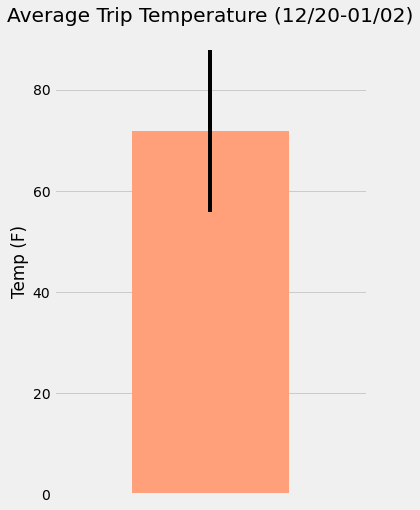

<Figure size 432x288 with 0 Axes>

In [30]:
# Plots the min, avg, and max temperature from this query as a bar chart, 
# using the average temperature as the bar height and the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR).
plt.figure(figsize=(5,8))
ax = temps_df['tavg'].plot.bar(yerr = (temps_df['tmax']-temps_df['tmin']), color='lightsalmon', title = "Average Trip Temperature (12/20-01/02)", ylabel = "Temp (F)")
ax.axes.get_xaxis().set_visible(False)
plt.show()
plt.tight_layout()
ax.figure.savefig('Average_Trip_temperature.png', bbox_inches='tight')


### Daily Rainfall Average

This section computes the daily "normals"(averages for min, average & max temperatures) for my Hawaii trip dates and generates an unstacked area chart to visualize them.  

- Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures. You are provided with a function called daily_normals that will calculate the daily normals for a specific date. This date string will be in the format %m-%d. Be sure to use all historic TOBS that match that date string.
- Create a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate the normals for each date string and append the results to a list.
- Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
- Use Pandas to plot an area plot (stacked=False) for the daily normals.

In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, 
       func.sum(Measurement.prcp),
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation
      ]
station_totals = session.query(*sel).\
        filter(Measurement.station == Station.station, func.strftime(Measurement.date) >= start_date, func.strftime(Measurement.date) <= end_date).\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()

station_totals


[('USC00516128',
  10.17,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  2.8899999999999997,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117', 2.17, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00514830',
  1.55,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519523',
  0.53,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397',
  0.24000000000000002,
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00517948', 0.06, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [32]:
# This function perfroms a query to calculate the daily normals for a given date 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# Set the start and end date of the trip (already set earlier in the notebook)
print(start_date, end_date)

2016-12-20 2017-01-02


In [34]:
# Use the start and end date to create a range of dates
form_start = dt.datetime.strptime(start_date,'%Y-%m-%d')
form_end = dt.datetime.strptime(end_date,'%Y-%m-%d')
trip_length = form_end - form_start

# Strip off the year and build a list of %m-%d stringsfor each date
normal_dates = []
for i in range(trip_length.days + 1):
    current_day = form_start + dt.timedelta(days=i)
    month_day = dt.datetime.strftime(current_day,'%m-%d')
    #normals.append(month_day)
    normal_dates.append(month_day)

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for day in normal_dates:
    normals.append(daily_normals(day)[0])


In [35]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals,columns=["Minimum Temperature", "Average Temperature", "Maximum Temperature"], index=[normal_dates])
normals_df.index = normals_df.index.get_level_values(0)
normals_df.head(100)

,Minimum Temperature,Average Temperature,Maximum Temperature
12-20,65.0,72.913043,81.0
12-21,67.0,72.139535,78.0
12-22,67.0,71.130435,77.0
12-23,61.0,70.346939,78.0
12-24,62.0,70.062500,78.0
12-25,60.0,71.750000,79.0
12-26,63.0,71.446809,77.0
12-27,62.0,71.916667,79.0
12-28,62.0,70.520833,77.0
12-29,57.0,70.291667,78.0


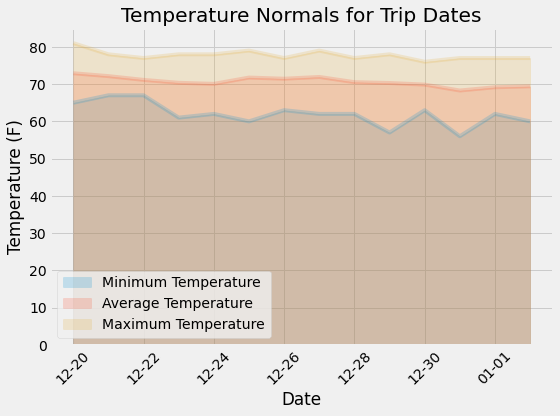

In [36]:
# Plot the daily normals as an area plot with `stacked=False`

ax = normals_df.plot(kind='area', stacked=False, alpha=.2, rot=45, title = "Temperature Normals for Trip Dates", xlabel='Date', ylabel = "Temperature (F)", figsize =(8,6))
plt.tight_layout()
plt.show()
ax.figure.savefig('TempNormalsforTrip.png', bbox_inches='tight')
